In [1]:
# -*- coding: utf-8 -*-
import utils as utils

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Flatten, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import numpy as np
import os

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import logging

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [2]:
all_teachers=5
teacher_id = 3
epochs = 175
shot = 10
SIAMESE_MODEL_NAME = '..\scripts\models_h5\siamese_network2c-t{}_{}notebook.h5'.format(teacher_id,shot)
EMBEDDING_MODEL_NAME = 'embedding_network2w_0729.h5'
if os.path.exists(SIAMESE_MODEL_NAME):
    os.remove(SIAMESE_MODEL_NAME)

In [3]:
base_dir = r"..\scripts\dataset"
dataset_path = os.path.join( r"..\scripts\auto_datasets", r"auto_t{}_{}\t{}-{}".format(all_teachers,shot,teacher_id, shot))
result_file_path = os.path.join(base_dir, r"true_result_xlsx")
pre_results_path = os.path.join(base_dir, r"teacher_results_xlsx","result_{}_{}".format(all_teachers,shot))
train_image_list, train_y_list = utils.load_images(dataset_path, 'train', (100, 100))
print("The train set contains", len(train_image_list))

Found 20 images belonging to 2 classes.
The train set contains 20


In [4]:
test_path = r"../scripts/dataset/pretrain_2c_0727/"
valid_image_list, valid_y_list = utils.load_images(test_path, 'valid', (100, 100))
print("The valid set contains", len(valid_image_list))

Found 1200 images belonging to 2 classes.
The valid set contains 1200


In [5]:
test_image_list, test_y_list = utils.load_images(test_path, 'test', (100, 100))
print("The test set contains", len(test_image_list))

Found 1200 images belonging to 2 classes.
The test set contains 1200


In [6]:
# make train pairs
pairs_train, labels_train, source_labels_train, true_labels_train = utils.make_pairs(train_image_list, train_y_list)

# make validation pairs
pairs_val, labels_val, source_labels_val, true_labels_val = utils.make_pairs(valid_image_list, valid_y_list)

# make validation pairs
pairs_test, labels_test, source_labels_test, true_labels_test = utils.make_pairs(test_image_list, test_y_list)

num_classes: 2
num_classes: 2
num_classes: 2


In [7]:
import pandas as pd

In [8]:
x_train_1 = pairs_train[:, 0]  # x1(如何给标签带上)
x_train_2 = pairs_train[:, 1]  # x2
print("number of pairs for train", np.shape(x_train_1)[0])

x_val_1 = pairs_val[:, 0]
x_val_2 = pairs_val[:, 1]
print("number of pairs for validation", np.shape(x_val_1)[0])

x_test_1 = pairs_test[:, 0]
x_test_2 = pairs_test[:, 1]
# print(x_test_1)
print("number of pairs for test", np.shape(x_test_1)[0])

number of pairs for train 40
number of pairs for validation 2400
number of pairs for test 2400


In [9]:
if not os.path.exists(result_file_path):
    os.makedirs(result_file_path)
result_xlsx=os.path.join(result_file_path,"true_labels.xlsx")
if not os.path.exists(result_xlsx):
    test_1_image_list = x_test_1.tolist()
    df = pd.DataFrame({"image": test_1_image_list, "true_label": true_labels_test})
    df.to_excel(result_xlsx, index=False)
    df = pd.read_excel(result_xlsx)
    df.drop_duplicates(inplace=True)
    df.to_excel(result_xlsx, index=False)

In [10]:
tf.compat.v1.reset_default_graph()

input_1 = Input((100, 100, 3))
input_2 = Input((100, 100, 3))

embedding_network = tf.keras.models.load_model(EMBEDDING_MODEL_NAME)
embedding_network.trainable = False

model = tf.keras.Sequential()
for layer in embedding_network.layers:
    model.add(layer)

model.add(Flatten(name='flat'))
model.add(Dense(5120, name='den', activation='sigmoid', kernel_regularizer='l2'))

output_1 = model(input_1)
output_2 = model(input_2)

merge_layer = Lambda(utils.manhattan_distance)([output_1, output_2])
output_layer = Dense(1, activation="sigmoid")(merge_layer)
siamese = Model(inputs=[input_1, input_2], outputs=output_layer)
siamese.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 5120)         14739266    ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [11]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta=0.0001)

checkpointer = ModelCheckpoint(filepath=SIAMESE_MODEL_NAME, verbose=1,
                               save_best_only=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 5120)         14739266    ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

Epoch 18/175
40/40 [==============================] - ETA: 0s - loss: 0.1325 - accuracy: 0.8000
Epoch 00018: val_loss did not improve from 0.14093
40/40 [==============================] - 382s 10s/step - loss: 0.1325 - accuracy: 0.8000 - val_loss: 0.1411 - val_accuracy: 0.9062 - lr: 1.0000e-04
Epoch 19/175
40/40 [==============================] - ETA: 0s - loss: 0.1327 - accuracy: 0.8000
Epoch 00019: val_loss improved from 0.14093 to 0.13987, saving model to ..\scripts\models_h5\siamese_network2c-t5_10notebook.h5
40/40 [==============================] - 399s 10s/step - loss: 0.1327 - accuracy: 0.8000 - val_loss: 0.1399 - val_accuracy: 0.9108 - lr: 1.0000e-04
Epoch 20/175
40/40 [==============================] - ETA: 0s - loss: 0.1318 - accuracy: 0.8000
Epoch 00020: val_loss improved from 0.13987 to 0.13901, saving model to ..\scripts\models_h5\siamese_network2c-t5_10notebook.h5
40/40 [==============================] - 406s 10s/step - loss: 0.1318 - accuracy: 0.8000 - val_loss: 0.1390 -

Epoch 42/175
40/40 [==============================] - ETA: 0s - loss: 0.1229 - accuracy: 0.9000
Epoch 00042: val_loss did not improve from 0.13082
40/40 [==============================] - 409s 10s/step - loss: 0.1229 - accuracy: 0.9000 - val_loss: 0.1309 - val_accuracy: 0.9304 - lr: 1.0000e-04
Epoch 43/175
40/40 [==============================] - ETA: 0s - loss: 0.1218 - accuracy: 0.9000
Epoch 00043: val_loss improved from 0.13082 to 0.12959, saving model to ..\scripts\models_h5\siamese_network2c-t5_10notebook.h5
40/40 [==============================] - 431s 11s/step - loss: 0.1218 - accuracy: 0.9000 - val_loss: 0.1296 - val_accuracy: 0.9408 - lr: 1.0000e-04
Epoch 44/175
40/40 [==============================] - ETA: 0s - loss: 0.1215 - accuracy: 0.8750
Epoch 00044: val_loss improved from 0.12959 to 0.12930, saving model to ..\scripts\models_h5\siamese_network2c-t5_10notebook.h5
40/40 [==============================] - 418s 11s/step - loss: 0.1215 - accuracy: 0.8750 - val_loss: 0.1293 -

Epoch 66/175
40/40 [==============================] - ETA: 0s - loss: 0.1142 - accuracy: 0.9250
Epoch 00066: val_loss did not improve from 0.12293
40/40 [==============================] - 207s 5s/step - loss: 0.1142 - accuracy: 0.9250 - val_loss: 0.1232 - val_accuracy: 0.9471 - lr: 1.0000e-04
Epoch 67/175
40/40 [==============================] - ETA: 0s - loss: 0.1138 - accuracy: 0.9250
Epoch 00067: val_loss improved from 0.12293 to 0.12235, saving model to ..\scripts\models_h5\siamese_network2c-t5_10notebook.h5
40/40 [==============================] - 206s 5s/step - loss: 0.1138 - accuracy: 0.9250 - val_loss: 0.1223 - val_accuracy: 0.9496 - lr: 1.0000e-04
Epoch 68/175
40/40 [==============================] - ETA: 0s - loss: 0.1133 - accuracy: 0.9250
Epoch 00068: val_loss did not improve from 0.12235
40/40 [==============================] - 207s 5s/step - loss: 0.1133 - accuracy: 0.9250 - val_loss: 0.1229 - val_accuracy: 0.9471 - lr: 1.0000e-04
Epoch 69/175
40/40 [=====================

Epoch 90/175
40/40 [==============================] - ETA: 0s - loss: 0.1068 - accuracy: 0.9500
Epoch 00090: val_loss did not improve from 0.11611
40/40 [==============================] - 205s 5s/step - loss: 0.1068 - accuracy: 0.9500 - val_loss: 0.1169 - val_accuracy: 0.9496 - lr: 1.0000e-04
Epoch 91/175
40/40 [==============================] - ETA: 0s - loss: 0.1070 - accuracy: 0.9250
Epoch 00091: val_loss improved from 0.11611 to 0.11570, saving model to ..\scripts\models_h5\siamese_network2c-t5_10notebook.h5
40/40 [==============================] - 208s 5s/step - loss: 0.1070 - accuracy: 0.9250 - val_loss: 0.1157 - val_accuracy: 0.9538 - lr: 1.0000e-04
Epoch 92/175
40/40 [==============================] - ETA: 0s - loss: 0.1062 - accuracy: 0.9250
Epoch 00092: val_loss improved from 0.11570 to 0.11536, saving model to ..\scripts\models_h5\siamese_network2c-t5_10notebook.h5
40/40 [==============================] - 217s 6s/step - loss: 0.1062 - accuracy: 0.9250 - val_loss: 0.1154 - va

40/40 [==============================] - ETA: 0s - loss: 0.1005 - accuracy: 1.0000
Epoch 00113: val_loss improved from 0.10999 to 0.10965, saving model to ..\scripts\models_h5\siamese_network2c-t5_10notebook.h5
40/40 [==============================] - 393s 10s/step - loss: 0.1005 - accuracy: 1.0000 - val_loss: 0.1097 - val_accuracy: 0.9588 - lr: 1.0000e-04
Epoch 114/175
40/40 [==============================] - ETA: 0s - loss: 0.1002 - accuracy: 1.0000 ETA: 2s - los
Epoch 00114: val_loss improved from 0.10965 to 0.10940, saving model to ..\scripts\models_h5\siamese_network2c-t5_10notebook.h5
40/40 [==============================] - 394s 10s/step - loss: 0.1002 - accuracy: 1.0000 - val_loss: 0.1094 - val_accuracy: 0.9583 - lr: 1.0000e-04
Epoch 115/175
40/40 [==============================] - ETA: 0s - loss: 0.1002 - accuracy: 0.9750
Epoch 00115: val_loss improved from 0.10940 to 0.10925, saving model to ..\scripts\models_h5\siamese_network2c-t5_10notebook.h5
40/40 [======================

40/40 [==============================] - 397s 10s/step - loss: 0.0941 - accuracy: 1.0000 - val_loss: 0.1039 - val_accuracy: 0.9583 - lr: 1.0000e-04
Epoch 137/175
40/40 [==============================] - ETA: 0s - loss: 0.0940 - accuracy: 1.0000
Epoch 00137: val_loss improved from 0.10388 to 0.10352, saving model to ..\scripts\models_h5\siamese_network2c-t5_10notebook.h5
40/40 [==============================] - 397s 10s/step - loss: 0.0940 - accuracy: 1.0000 - val_loss: 0.1035 - val_accuracy: 0.9617 - lr: 1.0000e-04
Epoch 138/175
40/40 [==============================] - ETA: 0s - loss: 0.0939 - accuracy: 1.0000
Epoch 00138: val_loss improved from 0.10352 to 0.10349, saving model to ..\scripts\models_h5\siamese_network2c-t5_10notebook.h5
40/40 [==============================] - 397s 10s/step - loss: 0.0939 - accuracy: 1.0000 - val_loss: 0.1035 - val_accuracy: 0.9583 - lr: 1.0000e-04
Epoch 139/175
40/40 [==============================] - ETA: 0s - loss: 0.0931 - accuracy: 1.0000
Epoch 001

Epoch 160/175
40/40 [==============================] - ETA: 0s - loss: 0.0877 - accuracy: 1.0000
Epoch 00160: val_loss improved from 0.09837 to 0.09817, saving model to ..\scripts\models_h5\siamese_network2c-t5_10notebook.h5
40/40 [==============================] - 254s 7s/step - loss: 0.0877 - accuracy: 1.0000 - val_loss: 0.0982 - val_accuracy: 0.9617 - lr: 1.0000e-04
Epoch 161/175
40/40 [==============================] - ETA: 0s - loss: 0.0875 - accuracy: 1.0000
Epoch 00161: val_loss improved from 0.09817 to 0.09791, saving model to ..\scripts\models_h5\siamese_network2c-t5_10notebook.h5
40/40 [==============================] - 459s 12s/step - loss: 0.0875 - accuracy: 1.0000 - val_loss: 0.0979 - val_accuracy: 0.9617 - lr: 1.0000e-04
Epoch 162/175
40/40 [==============================] - ETA: 0s - loss: 0.0873 - accuracy: 1.0000
Epoch 00162: val_loss improved from 0.09791 to 0.09780, saving model to ..\scripts\models_h5\siamese_network2c-t5_10notebook.h5
40/40 [=======================

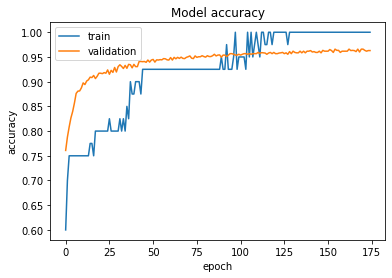

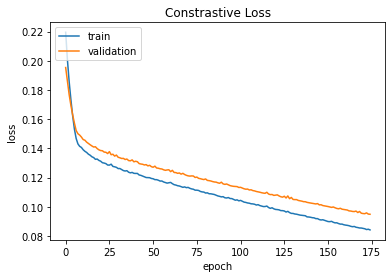

In [12]:
optimizer = Adam(learning_rate=0.0001)
siamese.compile(loss=utils.loss(1), optimizer=optimizer, metrics=["accuracy"])
# siamese.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

siamese.summary()
history = siamese.fit([x_train_1, x_train_2],
                      labels_train,
                      validation_data=([x_val_1, x_val_2], labels_val),
                      batch_size=1,
                      epochs=epochs,  # 175 for contrastive 100 for cross ent
                      callbacks=[checkpointer, early_stopping, reduce_lr]
                      )
# print()
# Plot the accuracy
utils.plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the constrastive loss
utils.plt_metric(history=history.history, metric="loss", title="Constrastive Loss")

In [13]:
results = siamese.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results)

75/75 [==============================] - 168s 2s/step - loss: 0.0976 - accuracy: 0.9600
test loss, test acc: [0.09764374792575836, 0.9599999785423279]


In [1]:
Y_pred = siamese.predict([x_test_1, x_test_2]).squeeze()
# 返回的是TRUE或FALSE,没有标签数据怎么知道他被分到哪儿个类中？
y_pred = Y_pred > 0.5
# x1,和x2是否匹配：匹配1，不匹配0
y_test = labels_test
print("\nEvaluate on validation data")
Accuracy=accuracy_score(y_test, y_pred)
Precision=precision_score(y_test, y_pred, average='weighted')
Recall=recall_score(y_test, y_pred, average='weighted')
ROC_AUC=roc_auc_score(y_test, y_pred, average='weighted')
F1=f1_score(y_test, y_pred, average='weighted')
print("Accuracy:", Accuracy)
print("Precision:", Precision)
print("Recall:", Recall)
print("ROC AUC:", ROC_AUC)
print("F1:",F1 )

NameError: name 'siamese' is not defined

In [ ]:
y_pred = [1 if i else 0 for i in y_pred]
pred_labels = []

for i in range(0, len(y_pred)):
    if y_pred[i] == 1:
        pred_labels += [source_labels_test[i]]
    else:
        if source_labels_test[i] == 1:
            pred_labels += [0.0]
        else:
            pred_labels += [1.0]
a = x_test_1.tolist()
df = pd.DataFrame({"image": a, "label_{}".format(teacher_id): pred_labels})
if not os.path.exists(pre_results_path):
    os.makedirs(pre_results_path)
df.to_excel(os.path.join(pre_results_path,"{}_{}_{}.xlsx".format(epochs,teacher_id,shot)),index=False)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.show()
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
print("Specificity:", specificity)
data_list=[{"Accuracy":Accuracy,"Precision":Precision,"Recall":Recall,"ROC_AUC":ROC_AUC,"tn":tn,"fp":fp,"fn":fn,"tp":tp,"specificity":specificity}]
df=pd.DataFrame(data_list)
all_teachers=5
filepath=os.path.join(base_dir,r"acc_{}_{}".format(all_teachers,shot))
if not os.path.exists(filepath):
    os.mkdir(filepath)
df.to_excel(os.path.join(filepath,"{}_{}.xlsx".format(teacher_id,shot)),index=False)
tf.keras.backend.clear_session()